In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.1.0,org.apache.kafka:kafka-clients:0.10.0-kafka-2.1.0 pyspark-shell'

In [2]:
#start spark session
spark = SparkSession\
        .builder\
        .appName("MovingAverage")\
        .getOrCreate()

        

In [3]:
import sys
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.sql.window import Window
from datetime import datetime

import pandas as pd
from pyspark.sql.types import DateType



df = spark.read.json("cryptodata.txt")
df = df.select(col("*"),from_unixtime(col("timestamp"),"MM/dd/yyyy").alias("date"))


In [4]:
df = df.drop(col("timestamp"))
df.printSchema
func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())
df1 = df.withColumn('date', func(col('date')))
df1.printSchema

<bound method DataFrame.printSchema of DataFrame[close: double, cryptocurrency: string, high: double, low: double, open: double, volume: double, date: date]>

In [9]:
#create a window for 7 day average
wma = Window.orderBy('date').rowsBetween(-7, 0)
wma_partitioned = Window.partitionBy('cryptocurrency').orderBy('date').rowsBetween(-7, 0)


In [38]:
#create respective dataframes for each currency
DF_ETH = df1.filter(df.cryptocurrency == "ETH")
DF_BTC = df1.filter(df.cryptocurrency == "BTC")
DF_ADA = df1.filter(df.cryptocurrency == "ADA")


In [10]:
#apply window function to each currency
DF_ETH_MA = DF_ETH.withColumn('7MA', avg("close").over(wma))
DF_BTC_MA = DF_BTC.withColumn('7MA', avg("close").over(wma))
DF_ADA_MA = DF_ADA.withColumn('7MA', avg("close").over(wma))


DF_ALL = df1.withColumn('7MA', avg("close").over(wma_partitioned))


In [ ]:
dfplot = DF_ETH_MA.select("date","7MA")
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
import matplotlib.pyplot as plt

spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%time pandas_df_ETH = dfplot.toPandas()

pandas_df_ETH.set_index('date', inplace=True)
pandas_df_ETH.head()


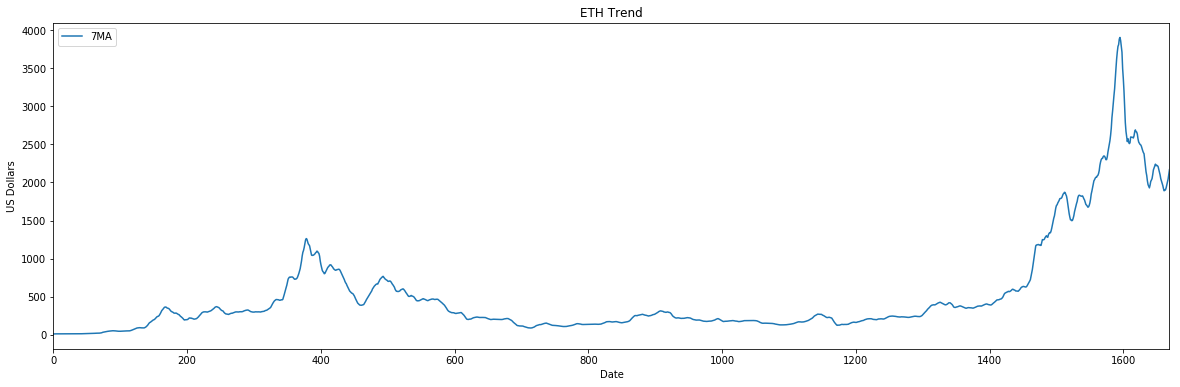

In [24]:
try:
    pandas_df_ETH.plot(kind='line',figsize=(20,6))
    plt.title('ETH Trend')
    plt.ylabel('US Dollars')
    plt.xlabel('Date')
    plt.show()
except ValueError:
    print("error")  

In [25]:
dfplot = DF_BTC_MA.select("date","7MA")
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
import matplotlib.pyplot as plt

spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%time pandas_df_BTC = dfplot.toPandas()

pandas_df_BTC.set_index('date', inplace=True)
pandas_df_BTC.head()


CPU times: user 9.29 ms, sys: 1.79 ms, total: 11.1 ms
Wall time: 241 ms


,7MA
date,
2017-01-02,1011.450
2017-01-03,1016.060
2017-01-04,1054.140
2017-01-05,1042.355
2017-01-06,1013.026


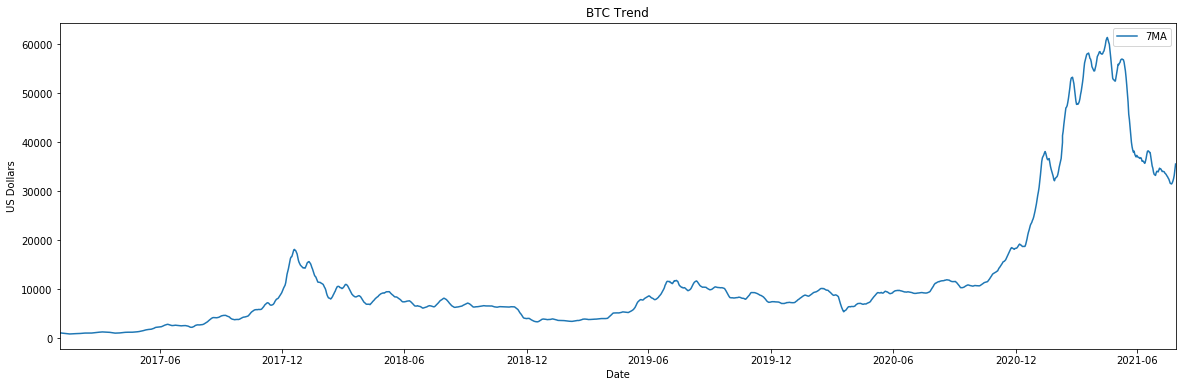

In [28]:
try:
    pandas_df_BTC.plot(kind='line',figsize=(20,6))
    plt.title('BTC Trend')
    plt.ylabel('US Dollars')
    plt.xlabel('Date')
    plt.show()
except ValueError:
    print("error")  

In [29]:
dfplot = DF_ADA_MA.select("date","7MA")
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
import matplotlib.pyplot as plt

spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%time pandas_df_ADA = dfplot.toPandas()

pandas_df_ADA.set_index('date', inplace=True)
pandas_df_ADA.head()


CPU times: user 2.2 ms, sys: 2.58 ms, total: 4.78 ms
Wall time: 227 ms


,7MA
date,
2021-03-18,1.23000
2021-03-19,1.26880
2021-03-20,1.24630
2021-03-21,1.23185
2021-03-22,1.20602


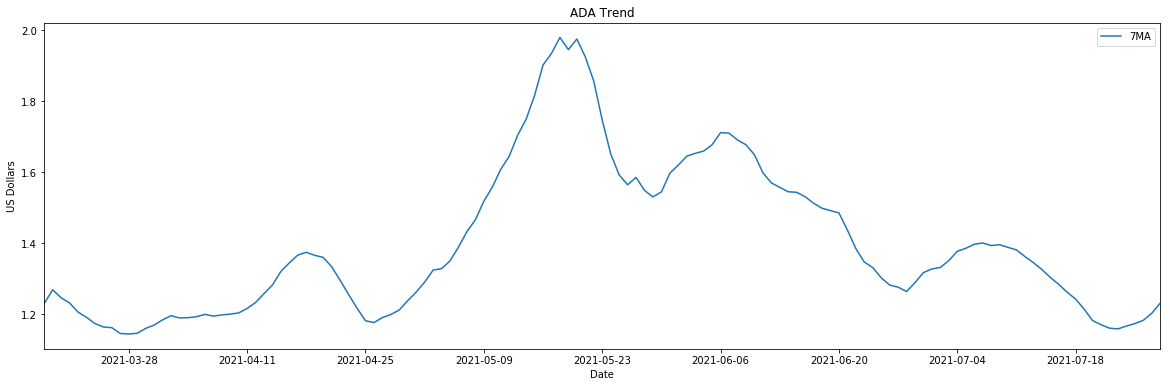

In [30]:
try:
    pandas_df_ADA.plot(kind='line',figsize=(20,6))
    plt.title('ADA Trend')
    plt.ylabel('US Dollars')
    plt.xlabel('Date')
    plt.show()
except ValueError:
    print("error")  

In [32]:
dfplot = DF_ALL.select("date","cryptocurrency","7MA")
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
import matplotlib.pyplot as plt

spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%time pandas_df_ALL = dfplot.toPandas()

pandas_df_ALL.set_index('date', inplace=True)

#pivot the dataframe to plot all 3 crypto against one figure.
pandas_df_ALL = pandas_df_ALL.pivot_table(index=['date'], 
            columns=['cryptocurrency'], values='7MA').fillna(0)
pandas_df_ALL.head()


CPU times: user 28.6 ms, sys: 2.7 ms, total: 31.3 ms
Wall time: 1.34 s


cryptocurrency,ADA,BTC,ETH
date,,,
2017-01-02,0.0,1011.450,8.380000
2017-01-03,0.0,1016.060,8.985000
2017-01-04,0.0,1054.140,9.713333
2017-01-05,0.0,1042.355,9.842500
2017-01-06,0.0,1013.026,9.902000


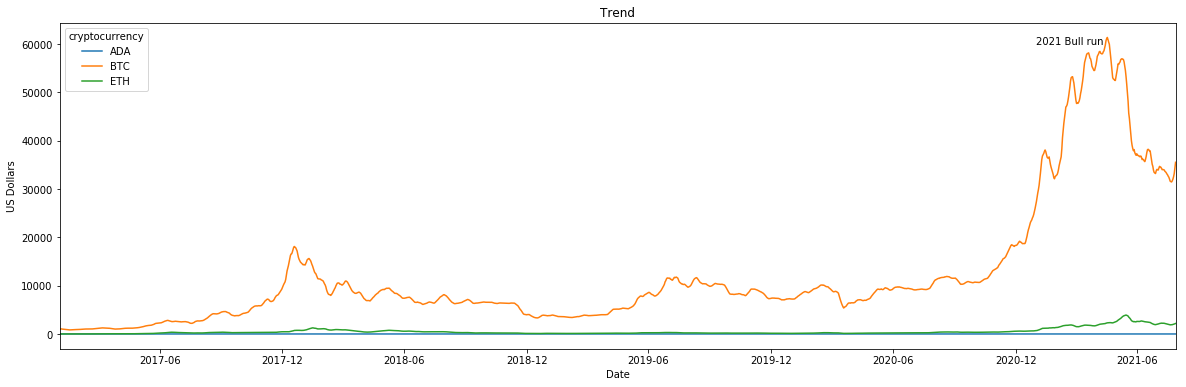

In [37]:
try:
    pandas_df_ALL.plot(kind='line',figsize=(20,6))
    plt.title('Trend')
    plt.ylabel('US Dollars')
    plt.xlabel('Date')
    plt.text('2021-01',60000,"2021 Bull run")
    plt.show()
except ValueError:
    print("error")  